# PAC/PVC/NORMAL BEAT CLASSIFICATION

## Part 1: feature extraction

In this notebook, we will analyze out data, perform pre-processing and extract features. In the end, we will save these features and upload them in 'Notebook2', where we will perform scaling, select relevant features only and then feed them to different classifiers, to identify the best one. 

## Import libraries

In [ ]:
from scipy.io import loadmat
import numpy as np, os, sys, joblib
import re
from os.path import dirname, join as pjoin
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# for colab
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Import Data

In [ ]:
input_directory = r'' # insert the directory of the training_set

The dataset contains 2-leads ecg signals from 105 patients, sampled at different Fs (128 or 250), along with the R peaks positions and the corresponding labels: 'N' -> normal, 'S' -> PAC; 'V' -> PVC


In [ ]:
# Extract path
for fname in input_directory:
    if os.path.isfile(input_directory + os.sep + fname):
        # Full path       
        f = (input_directory + os.sep + fname)
        print(f)   

In [ ]:
ann=[] # annotations
rpk=[] # r peaks positions 
signa=[] # ecg signals 

for f in os.listdir(input_directory): # create a list with all files 
    g = os.path.join(input_directory, f)
    if re.search(r'\w*ann.mat\b', f): # use regex library to save in ann all the files finishing with ann.mat
        ann.append(g)
        
    elif re.search(r'\w*rpk.mat\b', f): # use regex library to save in rpk all the files finishing with rpk.mat
        rpk.append(g)
        
    else:   # means this is the signal, so we save it in the variable signa
        signa.append(g) 
        

In [ ]:
# Sort the elements inside the vector
signa = sorted(signa)
ann=sorted(ann)
rpk=sorted(rpk)

In [ ]:
ecg_signals = [] # save all 2-leads ecg signals for the 105 patients 
R_loc=[] # 105 vectors with r peaks positions 
R_labels=[] # 105 vectors with r peaks labels

In [ ]:
# Save annotations
for i in range (0,len(ann)):
    x=loadmat(ann[i]) 
    R_labels.append(x['labels'])
    labels= [list(i) for i in R_labels]
#print(labels)
#print(len(labels))

In [ ]:
# Save R peaks
for i in range (0,len(rpk)):
    x=loadmat(rpk[i])
    R_loc.append(x['rpeaks'])
#print(R_loc)
#print(len(R_loc))

## Create a dataframe containing:
- Patient ID
- Sampling frequency Fs
- R peaks positions R_loc
- R peaks labels R_labels
- Lead 1 signal
- Lead 2 signal

### ID

In [ ]:
idx=[]
for f in signa: # this command creates a list with all files
    m = re.search('S(.+?)_', f)
    if m:
        idx.append(m.group(1))
    
#print(len(idx))    
#print(idx)

### Fs

In [ ]:
freq = []
for f in range (0, len(signa)):
    stringa = os.path.basename(os.path.normpath(signa[f]))

    m = re.search('_(.+?).mat', stringa)
    if m:
        freq.append(m.group(1))

#print(len(freq))    
#print(freq)

In [ ]:
# Create dataframe df with ID and Fs, then we will add R_loc, R_labels, ecg lead1 and ecg lead2
import pandas as pd
data={'ID':idx, 'Fs':freq}
df=pd.DataFrame(data)

### R peaks locations

In [ ]:
df['pos']=R_loc

### R peaks annotations

In [ ]:
df['label']=R_labels

### ECG signal

In [ ]:
ecg_signals = []
L1 = [] # lead1
L2 = [] # lead2

for i in range (0,len(signa)):
    x=loadmat(signa[i])
    leads=x['ecg']
    ecg_signals.append(x['ecg']) # this contains both leads
    L1.append(np.array(leads[:,0]))
    L2.append(np.array(leads[:,1]))

In [ ]:
df['lead1'] = L1
df['lead2'] = L2

In [ ]:
df.head()

,ID,Fs,pos,label,lead1,lead2
0,001,128,"[[29], [110], [191], [272], [353], [433], [514...","[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...","[0.0, 0.04, 0.03, 0.0, 0.03, 0.09, 0.18, 0.14,...","[0.08, 0.07, 0.1, 0.06, 0.06, 0.03, 0.1, 0.21,..."
1,002,128,"[[48], [153], [243], [352], [440], [547], [636...","[N, N, N, N, S, N, S, N, S, N, S, N, S, N, S, ...","[-0.035, -0.045, -0.025, -0.035, -0.045, -0.05...","[-0.095, -0.105, -0.095, -0.095, -0.115, -0.09..."
2,003,128,"[[91], [209], [326], [394], [537], [653], [745...","[N, N, N, S, N, N, S, N, N, S, N, N, N, N, N, ...","[-0.56, -0.56, -0.55, -0.47, -0.53, -0.47, -0....","[0.43, 0.56, 0.6, 0.41, 0.54, 0.48, 0.56, 0.46..."
3,004,128,"[[98], [223], [349], [474], [599], [726], [853...","[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...","[-0.46, -0.49, -0.52, -0.58, -0.62, -0.69, -0....","[0.56, 0.61, 0.66, 0.66, 0.63, 0.66, 0.59, 0.5..."
4,005,128,"[[27], [127], [225], [324], [423], [523], [623...","[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...","[-0.27, -0.17, -0.13, -0.23, -0.18, -0.23, -0....","[-0.02, -0.04, -0.01, -0.01, -0.02, -0.06, 0.0..."


# Preprocessing 


## Check for class unbalance

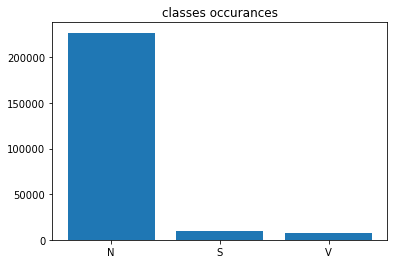

Normal:  226932

PAC:  9609

PVC:  7795


In [ ]:
# Label distribution
lab = np.array(df.label)

# Count labels 
normal=0
pac=0
pvc=0

for i in range (lab.size):
    for j in range (lab[i].size):       
        if lab[i][j] == 'N': #normal
            normal=normal+1
        elif lab[i][j] == 'S': #pac
            pac=pac+1
        elif lab[i][j] == 'V': #pvc
            pvc=pvc+1
            
classes = ['N','S','V']
pos = np.arange(len(classes))

plt.bar(pos, [normal, pac, pvc])
plt.xticks(pos, classes)
plt.title('classes occurances')
plt.show()

print('Normal: ', normal)
print('\nPAC: ', pac)
print('\nPVC: ', pvc)


As expected, the dataset in strongly unbalanced, containing a huge number of normal peaks with respect to the other two classes. 
In order to reduce a bit this condition, we decided to remove from the dataset signals coming from patients where all the labels were 'N'. 


In [ ]:
# Remove patients with only normal beats
lab = df['label']
df2 = df[0:1]

for p in range (1,len(lab)):
    
    lab100= lab[p]

    normal=0
    pac=0
    pvc=0

    for i in range (lab100.size):
        for j in range (lab100[i].size):       
            if lab100[i][j] == 'N':
                normal=normal+1
            elif lab100[i][j] == 'S':
                pac=pac+1
            elif lab100[i][j] == 'V':
                pvc=pvc+1
     
    if normal != len(lab100):        
        df2=df2.append(df[p:p+1],ignore_index=True)

In [ ]:
df2.head()

,ID,Fs,pos,label,lead1,lead2
0,001,128,"[[29], [110], [191], [272], [353], [433], [514...","[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...","[0.0, 0.04, 0.03, 0.0, 0.03, 0.09, 0.18, 0.14,...","[0.08, 0.07, 0.1, 0.06, 0.06, 0.03, 0.1, 0.21,..."
1,002,128,"[[48], [153], [243], [352], [440], [547], [636...","[N, N, N, N, S, N, S, N, S, N, S, N, S, N, S, ...","[-0.035, -0.045, -0.025, -0.035, -0.045, -0.05...","[-0.095, -0.105, -0.095, -0.095, -0.115, -0.09..."
2,003,128,"[[91], [209], [326], [394], [537], [653], [745...","[N, N, N, S, N, N, S, N, N, S, N, N, N, N, N, ...","[-0.56, -0.56, -0.55, -0.47, -0.53, -0.47, -0....","[0.43, 0.56, 0.6, 0.41, 0.54, 0.48, 0.56, 0.46..."
3,004,128,"[[98], [223], [349], [474], [599], [726], [853...","[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...","[-0.46, -0.49, -0.52, -0.58, -0.62, -0.69, -0....","[0.56, 0.61, 0.66, 0.66, 0.63, 0.66, 0.59, 0.5..."
4,005,128,"[[27], [127], [225], [324], [423], [523], [623...","[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...","[-0.27, -0.17, -0.13, -0.23, -0.18, -0.23, -0....","[-0.02, -0.04, -0.01, -0.01, -0.02, -0.06, 0.0..."
...,...,...,...,...,...,...
86,114,250,"[[155], [383], [611], [835], [1053], [1275], [...","[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...","[-0.22, -0.225, -0.23, -0.22, -0.185, -0.155, ...","[-0.86, -0.905, -0.94, -0.975, -1.0, -1.025, -..."
87,115,250,"[[215], [437], [667], [823], [1119], [1349], [...","[N, N, N, V, N, N, N, V, N, N, N, N, N, N, N, ...","[0.385, 0.35, 0.31, 0.285, 0.265, 0.25, 0.225,...","[0.515, 0.45, 0.38, 0.33, 0.3, 0.28, 0.25, 0.2..."
88,116,250,"[[255], [535], [817], [1093], [1377], [1657], ...","[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...","[-0.12, -0.12, -0.12, -0.125, -0.12, -0.115, -...","[-0.1, -0.105, -0.11, -0.125, -0.135, -0.13, -..."
89,117,250,"[[19], [295], [575], [863], [1151], [1435], [1...","[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...","[-0.045, -0.045, -0.045, -0.045, -0.045, -0.04...","[0.175, 0.185, 0.18, 0.175, 0.175, 0.175, 0.17..."


At this point, we have reduced the number of patients from 105 to 91. Of course, the label distribution remains unbalanced towards the 'N' class, as we can see in the next picture. 

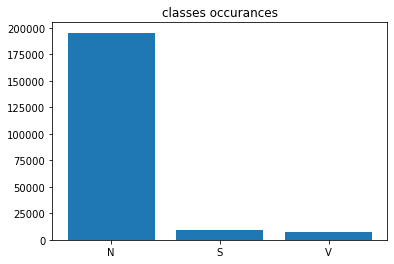

Normal:  195270

PAC:  9609

PVC:  7795


In [ ]:
# Label distribution df2
lab = np.array(df2.label)

normal=0
pac=0
pvc=0

for i in range (lab.size):
    for j in range (lab[i].size):       
        if lab[i][j] == 'N':
            normal=normal+1
        elif lab[i][j] == 'S':
            pac=pac+1
        elif lab[i][j] == 'V':
            pvc=pvc+1
            
classes = ['N','S','V']
pos = np.arange(len(classes))

plt.bar(pos, [normal, pac, pvc])
plt.xticks(pos, classes)
plt.title('classes occurances')
plt.show()

print('Normal: ', normal)
print('\nPAC: ', pac)
print('\nPVC: ', pvc)

In [ ]:
# Upadte R_loc and R_labels on df2, only keeping the 91 patients which have at least one 'S' or 'V'.
R_loc = df2['pos']
R_labels = df2['label']

In [ ]:
# We decided to encode the classes as integers. In particular, we have:
# class 0: normal 'N'
# class 1: pac 'S'
# class 2: pvc 'V' 

R_labels = np.concatenate(R_labels, axis =0)

for i in range( 0, len(R_labels)):
    
    if R_labels[i] == 'N':
        R_labels[i]=0
        R_labels[i]=int(R_labels[i])
        
    elif R_labels[i] == 'S':
        R_labels[i]=1
        R_labels[i]=int(R_labels[i])
        
    elif R_labels[i] == 'V':
        R_labels[i]=2
        R_labels[i]=int(R_labels[i])

## Resampling
Since the signals were sampled at different fs, we decided to resample at 128 Hz. 

In [ ]:
fs=128
T=1/fs

In [ ]:
import scipy.signal
d1 = np.array(df2.lead1)
d2 = np.array(df2.lead2)
f = np.array(df2.Fs)

for i in range (d1.size):
    signal_freq = int(f[i])
  
    if signal_freq == 250:
        secs = int(len(d1[i])/250) # Number of seconds in signal X
        samps = secs * 128   # Number of samples to downsample
        d1[i] = scipy.signal.resample(d1[i], samps)
        d2[i] = scipy.signal.resample(d2[i], samps)
        
        for j in range (0,len(R_loc[i])):
            R_loc[i][j] = R_loc[i][j]*128/250 # resample R_loc too. 

## Filtering
We applied a butterworth bandpass filter of order 3, keeping frequencies between 2Hz and 20 Hz.

In [ ]:
# Butterworth filter
from scipy.signal import butter, lfilter

def bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, data)
        return y

    

In [ ]:
# Values from literature
lowcut = 2.0 # lowcut frequency
highcut = 20.0 # highcut frequency
signal_freq = 128 # we resampled all the signals to 128Hz
filter_order = 3 

In [ ]:
# Create two lists, namely 'filtered1' and 'filtered2', containing the filtered signals (respectively, lead1 and lead2)
filtered1 = [] 
filtered2 = []
for i in range (d1.size):
    data = d1[i] # lead1 signal
    butter1 = bandpass_filter(data, lowcut, highcut, signal_freq, filter_order)
    filtered1.append(butter1)
    
    data = d2[i] #lead2 signal
    filtered2.append(bandpass_filter(data, lowcut, highcut, signal_freq, filter_order))

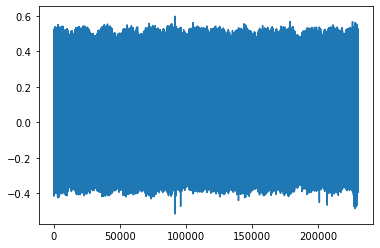

In [ ]:
plt.plot(filtered1[1])

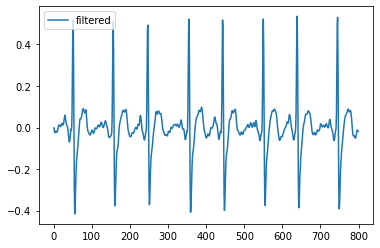

In [ ]:
# Visualize the signal before and after filtering:
pos=np.array(list(range(0,800)))
beat_butter = filtered1[1][pos] #after filtering
beat_original = d1[1][pos] # before filtering

plt.plot(beat_original,label="original")
plt.plot(beat_butter,label="filtered")
plt.legend(loc="upper left")
plt.show()

# Feature Extraction

## Temporal features
We computed:
- RR intervals: distance of two consecutive R peaks. In particular, we computed both RR_prima (R(i) - R(i-1)) and RR_dopo (R(i+1)-R(i))
- dRR: difference of consecutive RRs. In particular, we computed both dRR_prima and dRR_dopo.

Considering two different windows (3 and 15), centered on the current beat, we computed:
- Mean RR
- Standard deviation of RRs
- Standard deviation of dRRs
- Percentage of successive interval differences greater than 10, 20, 30, 40, and 50 ms (pNN10, pNN20, pNN30, pNN40, pNN50)
- Root Mean Square of Successive Differences (RMMSD) 

### RR intervals

In [ ]:
RR_prima = []
RR_dopo = []

for i in range(len(R_loc)): # span R_loc lenght, meaning the 91 patients
    RR_prima.append(np.nan) # add a 'nan' in the beginning because the first peak will have no RR_prima
    for j in range(1, len(R_loc[i])): # span all the R peaks inside each signal, starting from 1 up to the end
        RR_pre = R_loc[i][j][0] - R_loc[i][j-1][0] # R(i) - R(i-1)
        RR_prima.append(RR_pre) 
    for k in range(0, len(R_loc[i])-1): # span all the R peaks inside each signal, starting from 0 up to the end-1
        RR_post = R_loc[i][k+1][0] - R_loc[i][k][0]  # R(i+1) - R(i)
        RR_dopo.append(RR_post) 
    RR_dopo.append(np.nan) # add a 'nan' in the end because the last peak will have no RR_dopo


At this point, we check for outliers in the feature: 

In [ ]:
# Patient IDs
index = []
for i in range (0, len(R_loc)):
    indici =[]
    for j in range (0, len(R_loc[i])):
        indice = i
        indici.append(indice)
        
    index.append(indici)
    
index = np.concatenate(index, axis=0)

In [ ]:
# Dataframe containing the RR intervals 
RR_df = pd.DataFrame({'ID': index,                        
                        'RR_prima': RR_prima,
                        'RR_dopo': RR_dopo,                        
                        'label': R_labels
                       })

<AxesSubplot:>

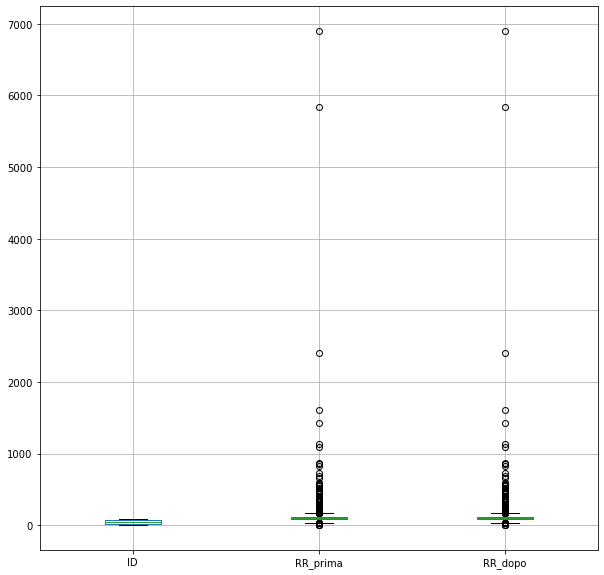

In [ ]:
RR_df.boxplot(figsize=(10,10))

We can notice the presence of outliers which appeared to be very strange. Thus, we explored the signals in order to understand where it happened and why. 

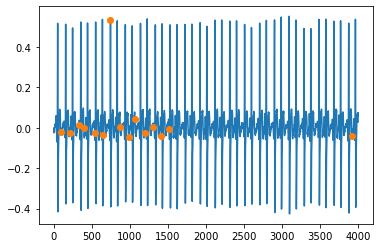

In [ ]:
# Let's look at where we have these outliers 
segnale = filtered1[1] #take a signal
segnale = segnale[0:4000] #take a portion of the signal
r=df['pos'][2] # take the r peaks position in the signals
r = r[0:15] # select come of these r peaks 

r_amp = segnale[r] 
plt.plot(segnale)
plt.plot(r, r_amp, 'o')

From this picture, we can see that some peaks were not annotated, and we assumed these were the ones causing outliers inside our RR intervals features. Thus, we decided to fix a normal range, taken from literature, considering RRmax = 3428.6ms. Whenever this distance was higher, we decided to set it to a normal value, namely 'rr_norm'. 

In [ ]:
# Compute RR intervals again
RR_prima = []
RR_dopo = []

rr_max = 3428 * 10**-3 *128 # taken from literature
rr_norm = 1 * 128

for i in range(len(R_loc)): 
    RR_prima.append(np.nan)
    for j in range(1, len(R_loc[i])):
        RR_pre = R_loc[i][j][0] - R_loc[i][j-1][0]
        
        # Check if RR intervals are in the normal range. If the value exceeds the threshold, we set it to a normal value.
        if RR_pre > rr_max:
            RR_prima.append(rr_norm)    
        else:     
            RR_prima.append(RR_pre)
            
    for k in range(0, len(R_loc[i])-1):
        RR_post = R_loc[i][k+1][0] - R_loc[i][k][0]
        
        if RR_post > rr_max:
            RR_dopo.append(rr_norm)
        else:     
            RR_dopo.append(RR_post)
    RR_dopo.append(np.nan)

In [ ]:
# df aggiornato contenente solo gli rr
RR_df = pd.DataFrame({'ID': index,                        
                        'RR_prima': RR_prima,
                        'RR_dopo': RR_dopo,                        
                        'label': R_labels
                       })

<AxesSubplot:>

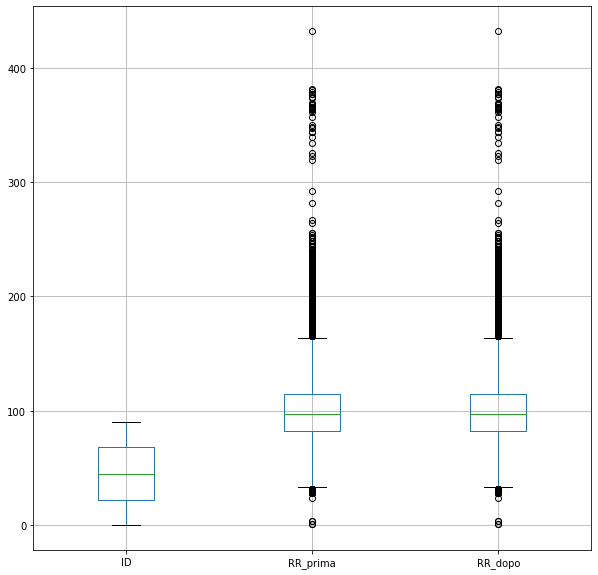

In [ ]:
RR_df.boxplot(figsize=(10,10))

From this plot, we can see that the problem was partially solved. However, there may still be some non-annotated beats which could influence the RR distance. However, this problem could be solved using other features, such as the RR mean.

### dRR

In [ ]:
dRR_prima = []
dRR_dopo = []
for i in range(0,len(RR_prima)-1): # span RR_prima, from 0 to the end-1
    dRR_pre = RR_prima[i+1] - RR_prima[i] # RR_prima(i+1) - RR_prima(i)
    dRR_post = RR_dopo[i+1] - RR_dopo[i] # RR_dopo(i+1) - RR_dopo(i)
    dRR_prima.append(dRR_pre)
    dRR_dopo.append(dRR_post)

dRR_prima.append(np.nan) # add a 'nan' in the end because for the last RR it is not possible to compute this difference
dRR_dopo.append(np.nan)


At this point, we check for outliers in the feature: 

In [ ]:
dRR_df = pd.DataFrame({'ID': index,                        
                        'dRR_prima': dRR_prima,
                        'dRR_dopo': dRR_dopo,                        
                        'label': R_labels
                       })

<AxesSubplot:>

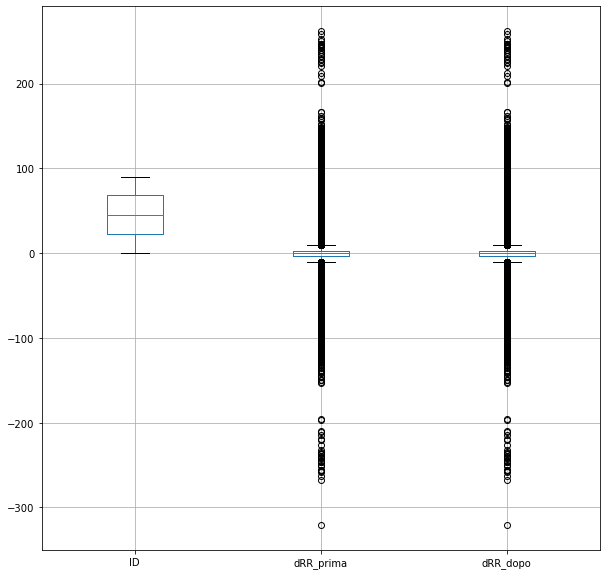

In [ ]:
dRR_df.boxplot(figsize=(10,10))

Since we used RR_prima and RR_dopo computed after our correction, these features appear to be fine.

### Mean RR and RR standard deviation, dRR standard deviation, Percentage of successive interval differences greater than 10, 20, 30, 40, and 50 ms , Root Mean Square of Successive Differences (RMSSD) 
We used two different windows, both centered on the current beat: 3 and 15 beats.

In [ ]:
# Function to compute mean RR and RR standard deviation:
def compute_mean_std(R_loc, window, rr_norm, rr_max):
    # This receives as input:
    # - R_loc: R peaks positions
    # - window: the window we want to use
    # - rr_max: the max_RR to accept 
    # - rr_norm: value to use as a correction whenever RR overcomes rr_max. 
    
    mean_RR = []
    std_RR = [] 
   
    for i in range(len(R_loc)): #span the patients
        mean_RR = np.append(mean_RR, np.repeat(np.nan, window)) #append as many 'nan' as the window length
        mean_RR = list(mean_RR)

        std_RR = np.append(std_RR, np.repeat(np.nan, window))
        std_RR = list(std_RR)

        
        for j in range(window, len(R_loc[i])-window): # span the content of each signal starting from window up to the end-window
            RR_meno_vect = [] 
            RR_piu_vect = []
            for k in range(0, window):
                RR_meno = abs(R_loc[i][j-k][0] - R_loc[i][j-k-1][0]) 
                if RR_meno > rr_max:
                    RR_meno = rr_norm
                RR_meno_vect.append(RR_meno)
                RR_piu = abs(R_loc[i][j+k+1][0] - R_loc[i][j+k][0])
                if RR_piu > rr_max:
                    RR_piu = rr_norm
                RR_piu_vect.append(RR_piu)
                
                RR_mean = np.mean([RR_meno_vect, RR_piu_vect])
                RR_std= np.std( [RR_meno_vect, RR_piu_vect])

            mean_RR.append(RR_mean)
            std_RR.append(RR_std)
 
        mean_RR = np.append(mean_RR, np.repeat(np.nan, window))
        mean_RR = list(mean_RR)
        std_RR = np.append(std_RR, np.repeat(np.nan, window))
        std_RR = list(std_RR)

    return mean_RR, std_RR


In [ ]:
# Function to compute mean RR and RR standard deviation:
def compute_stddRR_pNN_RMSSD(R_loc, window, m):
    # This function receives as input: 
    # - R_loc: R peaks positions
    # - window: the window to consider
    # - m: used to compute pNNm 

    std_dRR = []     
    pNN = []   
    RMSSD = [] 
    ms = m*(10**-3)*128   
    
    for i in range(0, len(R_loc)):  
        std_dRR = np.append(std_dRR, np.repeat(np.nan, window))
        std_dRR = list(std_dRR)
        
        pNN = np.append(pNN, np.repeat(np.nan, window))
        pNN = list(pNN)

        RMSSD = np.append(RMSSD, np.repeat(np.nan, window))
        RMSSD = list(RMSSD)
        
        for j in range(window, len(R_loc[i])-window):
            dRR_tot = []
            dRR = [] 
            
            for s in range(-window, window-1):     
                RR_1 = abs(R_loc[i][j+s+1][0] - R_loc[i][j+s][0])  
                RR_2 = abs(R_loc[i][j+s+2][0] - R_loc[i][j+s+1][0]) 
                d = RR_2 - RR_1
                dRR.append(d)
            dRR_tot.append(dRR)
            
            dRR_std= np.std(dRR_tot[0])
            std_dRR.append(dRR_std)

            # RMSSD
            dRR_rm = np.array(dRR_tot)
            RMSD = np.sqrt(np.mean(np.square(np.diff(dRR_rm))))
            RMSSD.append(RMSD)

            count = 0
            for l in range(0,len(dRR_tot[0])):
                if dRR_tot[0][l]> ms:
                    count=count+1
            pN=count/((2*window)-1)
            pNN.append(pN*100)
        
        std_dRR = np.append(std_dRR, np.repeat(np.nan, window))
        std_dRR = list(std_dRR)

        pNN = np.append(pNN, np.repeat(np.nan, window))
        pNN = list(pNN)

        RMSSD = np.append(RMSSD, np.repeat(np.nan, window))
        RMSSD = list(RMSSD)
    return std_dRR, pNN, RMSSD

#### 3 beats window

In [ ]:
rr_max = 3428 * 10**-3 *128
rr_norm = 1 * 128
window_3 = 3
mean_RR_3, std_RR_3 = compute_mean_std(R_loc, window_3, rr_norm, rr_max)
std_dRR_3, pNN_50_3, RMSSD_3 = compute_stddRR_pNN_RMSSD(R_loc, window_3, 50)

In [ ]:
_, pNN_10_3, _ = compute_stddRR_pNN_RMSSD(R_loc, window_3, 10) #pNN10
_, pNN_20_3, _ = compute_stddRR_pNN_RMSSD(R_loc, window_3, 20) #pNN20
_, pNN_30_3, _ = compute_stddRR_pNN_RMSSD(R_loc, window_3, 30) #pNN30
_, pNN_40_3, _ = compute_stddRR_pNN_RMSSD(R_loc, window_3, 40) #pNN40

#### 15 beats window

In [ ]:
rr_max = 3428 * 10**-3 *128
rr_norm = 1 * 128
window_15 = 15 
mean_RR_15, std_RR_15 = compute_mean_std(R_loc, window_15, rr_norm, rr_max)
std_dRR_15, pNN_50_15, RMSSD_15 = compute_stddRR_pNN_RMSSD(R_loc, window_15, 50)


In [ ]:
_, pNN_10_15, _ = compute_stddRR_pNN_RMSSD(R_loc, window_15, 10) #pNN10
_, pNN_20_15, _ = compute_stddRR_pNN_RMSSD(R_loc, window_15, 20) #pNN20
_, pNN_30_15, _ = compute_stddRR_pNN_RMSSD(R_loc, window_15, 30) #pNN30
_, pNN_40_15, _ = compute_stddRR_pNN_RMSSD(R_loc, window_15, 40) #pNN40


### Deal with the nan values introduced
When computing these features, we introduced some nan values. We evaluated different options, such as removing the rows, but it didn't seem correct since we needed to perform predictions on each and every beat, so we could not simply remove some of them. 
Thus, we decided to impute their value, using the intra-patient mean. 

In [ ]:
# Function to remove nan values and substitute them with the intra-patient mean
def remove_nan(R_loc, variable):
    # This function receives as input:
    # - R_loc: R peaks positions
    # - variable: the feature where we want to remove nan values.

    Variable = []
    k=0
    for i in range(0, len(R_loc)): # span R_loc
        l = len(R_loc[i]) # length of the R_loc vector for patient i
        paziente= variable[k : k+l] # extract the patient from the feature vector, which we created as a list (loosing ID reference)
        mean_var = np.nanmean(paziente) # compute the mean value of the specific feature for the specific patient, without nan
        paziente = np.where(np.isnan(paziente), mean_var, paziente) # substitute nan values with the computed mean
        Variable.append(paziente) 
        k=k+l 
    return Variable


In [ ]:
RR_prima = remove_nan(R_loc, RR_prima)
RR_dopo = remove_nan(R_loc, RR_dopo)
dRR_prima = remove_nan(R_loc, dRR_prima)
dRR_dopo = remove_nan(R_loc, dRR_dopo)
mean_RR_3 = remove_nan(R_loc, mean_RR_3)
std_RR_3 = remove_nan(R_loc, std_RR_3)
std_dRR_3 = remove_nan(R_loc, std_dRR_3 )
pNN_50_3 = remove_nan(R_loc, pNN_50_3 )
RMSSD_3 = remove_nan(R_loc, RMSSD_3)
pNN_10_3 = remove_nan(R_loc, pNN_10_3)
pNN_20_3 = remove_nan(R_loc, pNN_20_3 )
pNN_30_3 = remove_nan(R_loc, pNN_30_3)
pNN_40_3 = remove_nan(R_loc, pNN_40_3)
mean_RR_15 = remove_nan(R_loc, mean_RR_15)
std_RR_15 = remove_nan(R_loc, std_RR_15)
std_dRR_15 = remove_nan(R_loc, std_dRR_15)
pNN_50_15 = remove_nan(R_loc, pNN_50_15)
RMSSD_15 = remove_nan(R_loc, RMSSD_15)
pNN_10_15 = remove_nan(R_loc, pNN_10_15)
pNN_20_15 = remove_nan(R_loc, pNN_20_15)
pNN_30_15 = remove_nan(R_loc, pNN_30_15)
pNN_40_15 = remove_nan(R_loc, pNN_40_15)

In [ ]:
RR_prima =np.concatenate(RR_prima, axis=0)
RR_dopo =np.concatenate(RR_dopo, axis=0)
dRR_prima =np.concatenate(dRR_prima, axis=0)
dRR_dopo =np.concatenate(dRR_dopo, axis=0)
mean_RR_3 =np.concatenate(mean_RR_3, axis=0)
std_RR_3 =np.concatenate(std_RR_3, axis=0)
std_dRR_3 =np.concatenate(std_dRR_3, axis=0)
pNN_50_3 =np.concatenate(pNN_50_3, axis=0)
RMSSD_3 =np.concatenate(RMSSD_3, axis=0)
pNN_10_3 =np.concatenate(pNN_10_3, axis=0)
pNN_20_3 =np.concatenate(pNN_20_3, axis=0)
pNN_30_3 =np.concatenate(pNN_30_3, axis=0)
pNN_40_3 =np.concatenate(pNN_40_3, axis=0)
mean_RR_15 =np.concatenate(mean_RR_15, axis=0)
std_RR_15 =np.concatenate(std_RR_15, axis=0)
std_dRR_15 =np.concatenate(std_dRR_15, axis=0)
pNN_50_15 =np.concatenate(pNN_50_15, axis=0)
RMSSD_15 =np.concatenate(RMSSD_15, axis=0)
pNN_10_15 =np.concatenate(pNN_10_15, axis=0)
pNN_20_15 =np.concatenate(pNN_20_15, axis=0)
pNN_30_15 =np.concatenate(pNN_30_15, axis=0)
pNN_40_15 =np.concatenate(pNN_40_15, axis=0)

## Morphological features
We computed, for each lead: 
- Beats amplitude.
- QRS, P wave and PR segment amplitudes. 
- Maximum Cross correlation, using an intra-patient template obtained considering three different windows (4, 20, 80)
- Lag corresponding to the cross-correlation value described above.

In [ ]:
# Function to normalize data to have mean = 0 and standard deviation = 1
def norm_data(data):
    mean_data=np.mean(data)
    std_data=np.std(data, ddof=1)
    return (data-mean_data)/(std_data)

In [ ]:
# Function to compute:
# - the beats amplitude 
# - the cross correlation between neighboring beats, considering 3 windows: 
#       - 4 beats (2 before and 2 after the current beat)
#       - 20 beats (10 before and 10 after the current beat)
#       - 80 beats (40 before and 40 after the current beat)
# After aligning beats with cross-correlation, we will discard outliers and compute intra-patient templates, which will then be used 
# to compute cross correlation between the template and each beat. The maximum cross correlation of each segment will be used as a feature. 

# Starting from the R peak, we consider the beat as the portion going from –300 to + 250 ms, as found in literature. 
def compute_amplitude_correlation(sig, R_loc, T, window):
    # This function receives as input:
    # - sig: input signal
    # - R_loc: R peaks locations
    # T: period, defined as 1/Fs
    # window: the window to compute the intra-patient template

    beats= []
    correlation = []
    ampiezze = []

    for i in range(0,len(R_loc)): # span the patients
        amp = []
        battiti=[]
        correlazione = []
        signal=sig[i]
                
        correlazione = np.append(correlazione, np.repeat(np.nan, window+1)) #append nan values as the beginning
        correlazione = list(correlazione)
                
        for k in range (0,window+1): 
            if k==0: # if we are at the beginning of the signal, we cannot go back, thus, we go from 0 to +0.250ms
                b=signal[0:int(R_loc[i][k])+round(0.250/T)]
                        
                a = abs(np.max(b) - np.min(b)) # compute the amplitude as the difference between the maximum and the minimum of the beat
                amp.append(a)
                        
                b = norm_data(b) # normalize the beat to have 0 mean and standard deviation = 1
                battiti.append(b)
            else:
                b=signal[int(R_loc[i][k])-round(0.3/T):int(R_loc[i][k])+round(0.250/T)] # R - 300ms:R + 250 MS
                        
                a = abs(np.max(b) - np.min(b))
                amp.append(a)
                        
                b = norm_data(b)
                battiti.append(b)
               
        for j in range (window+1,(len(R_loc[i])-(window+1))): 
            c = []
            corre = []    
           
            b2=signal[int(R_loc[i][j])-round(0.3/T):int(R_loc[i][j])+round(0.250/T)] # current beat
            a = abs(np.max(b2) - np.min(b2))
            amp.append(a)
            
            b2 = norm_data(b2)
            battiti.append(b2)
            
            for s in range(1, window+1):
                
                b0=signal[int(R_loc[i][j-s])-round(0.3/T):int(R_loc[i][j-s])+round(0.250/T)] # beats in the window before the current beat
                b0 = norm_data(b0)
                        
                b3=signal[int(R_loc[i][j+s])-round(0.3/T):int(R_loc[i][j+s])+round(0.250/T)] # beats in the window after the current beat
                b3 = norm_data(b3)
                        
                corr0 = np.correlate(b0, b2) * (1.0/(b2.size-1)) # cross correlation between the current beat b2 and the previous beats 
                c.append(corr0)       
                corr3 = np.correlate(b3, b2) * (1.0/(b2.size-1)) # cross correlation between the current beat b2 and the following beats 
                c.append(corr3) 

            corre.append(c) # store the cross correlation values in each window
            
        
            corr = np.mean(corre) # compute the mean of the cross correlation values and store them in 'correlazione'
            correlazione.append(corr)
            
        for m in range (len(R_loc[i])-(window+1),len(R_loc[i])):
            if m==len(R_loc[i]): #for the last beat, we have to stop at the end of the signal and we cannot go after. 
                b=signal[int(R_loc[i][m])-round(0.3/T):len(R_loc[i])]
                        
                a = abs(np.max(b) - np.min(b))
                amp.append(a)
                        
                b = norm_data(b)
                battiti.append(b)
            else:
                b=signal[int(R_loc[i][m])-round(0.3/T):int(R_loc[i][m])+round(0.250/T)]
                        
                a = abs(np.max(b) - np.min(b))
                amp.append(a)
                        
                b = norm_data(b)
                battiti.append(b)
            
        correlazione = np.append(correlazione, np.repeat(np.nan, window+1)) # add nan values in the end
        correlazione = list(correlazione)
                
        correlation.append(correlazione)  # cross correlation  
        beats.append(battiti) # beats 
        ampiezze.append(amp) # amplitudes
    return correlation, ampiezze, beats

In [ ]:
# Function to create intra-patient templates
def create_templates(correlation, beats):
  # The function receives as inputs:
  # - correlation: cross correlation values obtained with the previous function ('compute_amplitude_correlation')
  # - beats: beats extracted using values from literature (-300ms; +250ms from the R peak)
    
    threshold = 0.75 # threshold to remove outliers
    templates = []
    for i in range(0, len(correlation)): 
        template = []
        for j in range(0, len(correlation[i])):
            if correlation[i][j] > threshold: # if the cross correlation overcomes the threshold, we store it to create the template            
                template.append(beats[i][j])

        if len(template) == 0:  
          m =-100

          for k in range (0, len(correlation[i])):
            m_old = m
            m = correlation[i][k]

            if m > m_old:
              massimo = m # update the maximum
              id = k # update the corresponding index

          template.append(beats[i][id])
          template = np.concatenate(template) # to fix dimensions        
        
        else: 
            template = np.mean(template, axis = 0)

        templates.append(template)

    return templates
            

In [ ]:
def cross_corr(y1, y2):

  if len(y1) != len(y2):
    raise ValueError('The lengths of the inputs should be the same.')
  y1_auto_corr = np.dot(y1, y1) / len(y1)
  y2_auto_corr = np.dot(y2, y2) / len(y1)
  corr = np.correlate(y1, y2, mode='same')
  # The unbiased sample size is N - lag.
  unbiased_sample_size = np.correlate(np.ones(len(y1)), np.ones(len(y1)), mode='same')
  corr = corr / unbiased_sample_size / np.sqrt(y1_auto_corr * y2_auto_corr)
  shift = len(y1) // 2
  max_corr = np.max(corr)
  argmax_corr = np.argmax(corr)

  return max_corr, argmax_corr - shift

In [ ]:
# Function to compare each beat of the subject with the corresponding template using cross-correlation.
def compute_max_cross_corr_lag(templates, beats):
    lag_corr=[]
    maximum_cross_correlation = []

    for i in range(0, len(beats)):
        template = templates[i]
        correl = []
        l=[]
        for j in range(0, len(beats[i])):
          if len(template) != len(beats[i][j]):
              print('lunghezze:', len(template), len(beats[i][j]), i,j)
          corr, lag = cross_corr(template, beats[i][j])
          correl.append(corr)
          l.append(lag)

            
        maximum_cross_correlation.append(correl)
        lag_corr.append(l)
    return maximum_cross_correlation, lag_corr


In [ ]:
def pad_beats(beats, n):
    for j in range (0, len(beats)):
        for i in range (0, (len(beats[j]))):
            if len(beats[j][i]) < n:
                beats[j][i] = np.pad(beats[j][i], (n - len(beats[j][i])-1,1), 'mean')
            elif len(beats[j][i]) > n:
                s=len(beats[j][i]) - n -1 
                beats[j][i]=beats[j][i][s:-1] 
    return beats

In [ ]:
# Function to compute:
# - the qrs amplitude 
# - the cross correlation between neighboring QRSs, considering 3 windows: 
#       - 4 beats (2 before and 2 after the current beat)
#       - 20 beats (10 before and 10 after the current beat)
#       - 80 beats (40 before and 40 after the current beat)
# After aligning QRSs with cross-correlation, we will discard outliers and compute intra-patient templates, which will then be used 
# to compute cross correlation between the template and each QRS. The maximum cross correlation of each segment will be used as a feature. 

# Starting from the R peak, we consider the QRS as the portion going from –70 to +60 ms, as found in literature. 
def compute_amplitude_correlation_qrs(sig, R_loc, T, window):
    qrs= []
    correlation_qrs = []
    ampiezze_qrs = []

    for i in range(0,len(R_loc)):
        amp = []
        battiti=[]
        correlazione = []
        signal=sig[i]
                
        correlazione = np.append(correlazione, np.repeat(np.nan, window+1))
        correlazione = list(correlazione)
                
        for k in range (0,window+1):
            if k==0:
                b=signal[0:int(R_loc[i][k])+round(0.06/T)]
                        
                a = abs(np.max(b) - np.min(b))
                amp.append(a)
                        
                b = norm_data(b)
                battiti.append(b)
            else:
                b=signal[int(R_loc[i][k])-round(0.07/T):int(R_loc[i][k])+round(0.06/T)] # - 300ms + 250 ms
                        
                a = abs(np.max(b) - np.min(b))
                amp.append(a)
                        
                b = norm_data(b)
                battiti.append(b)
               
        for j in range (window+1,(len(R_loc[i])-(window+1))):
            c = []
            corre = []    
           
            b2=signal[int(R_loc[i][j])-round(0.07/T):int(R_loc[i][j])+round(0.06/T)] # current beat
            a = abs(np.max(b2) - np.min(b2))
            amp.append(a)
            
            b2 = norm_data(b2)
            battiti.append(b2)
            
            for s in range(1, window+1):
                
                b0=signal[int(R_loc[i][j-s])-round(0.07/T):int(R_loc[i][j-s])+round(0.06/T)]
                b0 = norm_data(b0)
                        
                b3=signal[int(R_loc[i][j+s])-round(0.07/T):int(R_loc[i][j+s])+round(0.06/T)]
                b3 = norm_data(b3)
                        
                corr0 = np.correlate(b0, b2) * (1.0/(b2.size-1))
                c.append(corr0)       
                corr3 = np.correlate(b3, b2) * (1.0/(b2.size-1))
                c.append(corr3) 

            corre.append(c)
            
        
            corr = np.mean(corre)
            correlazione.append(corr)
            
        for m in range (len(R_loc[i])-(window+1),len(R_loc[i])):
            if m==len(R_loc[i]):
                b=signal[int(R_loc[i][m])-round(0.07/T):len(R_loc[i])]
                        
                a = abs(np.max(b) - np.min(b))
                amp.append(a)
                        
                b = norm_data(b)
                battiti.append(b)
            else:
                b=signal[int(R_loc[i][m])-round(0.07/T):int(R_loc[i][m])+round(0.06/T)]
                        
                a = abs(np.max(b) - np.min(b))
                amp.append(a)
                        
                b = norm_data(b)
                battiti.append(b)
            
        correlazione = np.append(correlazione, np.repeat(np.nan, window+1))
        correlazione = list(correlazione)
                
        correlation_qrs.append(correlazione)    
        qrs.append(battiti)
        ampiezze_qrs.append(amp)
    return correlation_qrs, ampiezze_qrs, qrs

In [ ]:
# Function to compute:
# - the P wave amplitude 
# - the cross correlation between neighboring P waves, considering 3 windows: 
#       - 4 beats (2 before and 2 after the current beat)
#       - 20 beats (10 before and 10 after the current beat)
#       - 80 beats (40 before and 40 after the current beat)
# After aligning P waves with cross-correlation, we will discard outliers and compute intra-patient templates, which will then be used 
# to compute cross correlation between the template and each P wave. The maximum cross correlation of each segment will be used as a feature. 

# Starting from the R peak, we consider the P wave as the portion going from –300 to +40 ms, as found in literature. 
def compute_amplitude_correlation_p(sig, R_loc, T, window):
    p = []
    correlation_p = []
    ampiezze_p = []

    for i in range(0,len(R_loc)):
        amp = []
        battiti=[]
        correlazione = []
        signal=sig[i]
                
        correlazione = np.append(correlazione, np.repeat(np.nan, window+1))
        correlazione = list(correlazione)
                
        for k in range (0,window+1):
            if k==0:
                b=signal[0:int(R_loc[i][k])+round(0.04/T)]
                        
                a = abs(np.max(b) - np.min(b))
                amp.append(a)
                        
                b = norm_data(b)
                battiti.append(b)
            else:
                b=signal[int(R_loc[i][k])-round(0.3/T):int(R_loc[i][k])+round(0.04/T)] # - 300ms + 250 ms
                        
                a = abs(np.max(b) - np.min(b))
                amp.append(a)
                        
                b = norm_data(b)
                battiti.append(b)
               
        for j in range (window+1,(len(R_loc[i])-(window+1))):
            c = []
            corre = []    
           
            b2=signal[int(R_loc[i][j])-round(0.3/T):int(R_loc[i][j])+round(0.04/T)] # current beat
            a = abs(np.max(b2) - np.min(b2))
            amp.append(a)
            
            b2 = norm_data(b2)
            battiti.append(b2)
            
            for s in range(1, window+1):
                
                b0=signal[int(R_loc[i][j-s])-round(0.3/T):int(R_loc[i][j-s])+round(0.04/T)]
                b0 = norm_data(b0)
                        
                b3=signal[int(R_loc[i][j+s])-round(0.3/T):int(R_loc[i][j+s])+round(0.04/T)]
                b3 = norm_data(b3)
                        
                corr0 = np.correlate(b0, b2) * (1.0/(b2.size-1))
                c.append(corr0)       
                corr3 = np.correlate(b3, b2) * (1.0/(b2.size-1))
                c.append(corr3) 

            corre.append(c)
            
        
            corr = np.mean(corre)
            correlazione.append(corr)
            
        for m in range (len(R_loc[i])-(window+1),len(R_loc[i])):
            if m==len(R_loc[i]):
                b=signal[int(R_loc[i][m])-round(0.3/T):len(R_loc[i])+round(0.04/T)]
                        
                a = abs(np.max(b) - np.min(b))
                amp.append(a)
                        
                b = norm_data(b)
                battiti.append(b)
            else:
                b=signal[int(R_loc[i][m])-round(0.3/T):int(R_loc[i][m])+round(0.04/T)]
                        
                a = abs(np.max(b) - np.min(b))
                amp.append(a)
                        
                b = norm_data(b)
                battiti.append(b)
            
        correlazione = np.append(correlazione, np.repeat(np.nan, window+1))
        correlazione = list(correlazione)
                
        correlation_p.append(correlazione)    
        p.append(battiti)
        ampiezze_p.append(amp)
    return correlation_p, ampiezze_p, p

In [ ]:
# Function to compute:
# - the PR segment amplitude 
# - the cross correlation between neighboring PR segments, considering 3 windows: 
#       - 4 beats (2 before and 2 after the current beat)
#       - 20 beats (10 before and 10 after the current beat)
#       - 80 beats (40 before and 40 after the current beat)
# After aligning PR segments with cross-correlation, we will discard outliers and compute intra-patient templates, which will then be used 
# to compute cross correlation between the template and each PR segment. The maximum cross correlation of each segment will be used as a feature. 

# Starting from the R peak, we consider the PR segment as the portion going from –288 to +0 ms, as found in literature. 
def compute_amplitude_correlation_pr(sig, R_loc, T, window):
    pr = []
    correlation_pr = []
    ampiezze_pr = []

    for i in range(0,len(R_loc)):
        amp = []
        battiti=[]
        correlazione = []
        signal=sig[i]
                
        correlazione = np.append(correlazione, np.repeat(np.nan, window+1))
        correlazione = list(correlazione)
                
        for k in range (0,window+1):
            if k==0:
                b=signal[0:int(R_loc[i][k])]
                        
                a = abs(np.max(b) - np.min(b))
                amp.append(a)
                        
                b = norm_data(b)
                battiti.append(b)
            else:
                b=signal[int(R_loc[i][k])-round(0.288/T):int(R_loc[i][k])] # - 300ms + 250 ms
                        
                a = abs(np.max(b) - np.min(b))
                amp.append(a)
                        
                b = norm_data(b)
                battiti.append(b)
               
        for j in range (window+1,(len(R_loc[i])-(window+1))):
            c = []
            corre = []    
           
            b2=signal[int(R_loc[i][j])-round(0.288/T):int(R_loc[i][j])] # current beat
            a = abs(np.max(b2) - np.min(b2))
            amp.append(a)
            
            b2 = norm_data(b2)
            battiti.append(b2)
            
            for s in range(1, window+1):
                
                b0=signal[int(R_loc[i][j-s])-round(0.288/T):int(R_loc[i][j-s])]
                b0 = norm_data(b0)
                        
                b3=signal[int(R_loc[i][j+s])-round(0.288/T):int(R_loc[i][j+s])]
                b3 = norm_data(b3)
                        
                corr0 = np.correlate(b0, b2) * (1.0/(b2.size-1))
                c.append(corr0)       
                corr3 = np.correlate(b3, b2) * (1.0/(b2.size-1))
                c.append(corr3) 

            corre.append(c)
            
        
            corr = np.mean(corre)
            correlazione.append(corr)
            
        for m in range (len(R_loc[i])-(window+1),len(R_loc[i])):
            if m==len(R_loc[i]):
                b=signal[int(R_loc[i][m])-round(0.288/T):len(R_loc[i])]
                        
                a = abs(np.max(b) - np.min(b))
                amp.append(a)
                        
                b = norm_data(b)
                battiti.append(b)
            else:
                b=signal[int(R_loc[i][m])-round(0.288/T):int(R_loc[i][m])]
                        
                a = abs(np.max(b) - np.min(b))
                amp.append(a)
                        
                b = norm_data(b)
                battiti.append(b)
            
        correlazione = np.append(correlazione, np.repeat(np.nan, window+1))
        correlazione = list(correlazione)
                
        correlation_pr.append(correlazione)    
        pr.append(battiti)
        ampiezze_pr.append(amp)
    return correlation_pr, ampiezze_pr, pr

### Window = 4, lead 1

In [ ]:
# Beats
T = 1/128
correlation_4, ampiezze, beats = compute_amplitude_correlation(filtered1, R_loc, T, 2)
templates_4 = create_templates(correlation_4, beats)
beats = pad_beats(beats, 70)
maximum_cross_correlation_4, lag_corr_4 = compute_max_cross_corr_lag(templates_4, beats)

In [ ]:
# QRS
correlation_qrs_4, ampiezze_qrs, qrs = compute_amplitude_correlation_qrs(filtered1, R_loc, T, 2)
templates_qrs_4 = create_templates(correlation_qrs_4, qrs)
qrs = pad_beats(qrs, 17)
maximum_cross_correlation_qrs_4, lag_corr_qrs_4 = compute_max_cross_corr_lag(templates_qrs_4, qrs)

In [ ]:
# P wave
correlation_p_4, ampiezze_p, p = compute_amplitude_correlation_p(filtered1, R_loc, T, 2)
templates_p_4 = create_templates(correlation_p_4, p)
p = pad_beats(p, len(templates_p_4[0]))
maximum_cross_correlation_p_4, lag_corr_p_4 = compute_max_cross_corr_lag(templates_p_4, p)

In [ ]:
# PR segment
correlation_pr_4, ampiezze_pr, pr = compute_amplitude_correlation_pr(filtered1, R_loc, T, 2)
templates_pr_4 = create_templates(correlation_pr_4, pr)
pr = pad_beats(pr, len(templates_pr_4[0]))
maximum_cross_correlation_pr_4, lag_corr_pr_4 = compute_max_cross_corr_lag(templates_pr_4, pr)

### Window = 20, lead 1

In [ ]:
# Beats
correlation_20, _, _ = compute_amplitude_correlation(filtered1, R_loc, T, 10)
templates_20 = create_templates(correlation_20, beats)

maximum_cross_correlation_20, lag_corr_20 = compute_max_cross_corr_lag(templates_20, beats)

In [ ]:
# QRS
correlation_qrs_20,_,_ = compute_amplitude_correlation_qrs(filtered1, R_loc, T, 10)
templates_qrs_20 = create_templates(correlation_qrs_20, qrs)
maximum_cross_correlation_qrs_20, lag_corr_qrs_20 = compute_max_cross_corr_lag(templates_qrs_20, qrs)

In [ ]:
# P wave
correlation_p_20, _, _ = compute_amplitude_correlation_p(filtered1, R_loc, T, 10)
templates_p_20 = create_templates(correlation_p_20, p)
maximum_cross_correlation_p_20, lag_corr_p_20 = compute_max_cross_corr_lag(templates_p_20, p)

In [ ]:
# PR segment
correlation_pr_20, _, _ = compute_amplitude_correlation_pr(filtered1, R_loc, T, 10)
templates_pr_20 = create_templates(correlation_pr_20, pr)
maximum_cross_correlation_pr_20, lag_corr_pr_20 = compute_max_cross_corr_lag(templates_pr_20, pr)

### Window = 80, lead 1

In [ ]:
# Beats
correlation_80, _, _ = compute_amplitude_correlation(filtered1, R_loc, T, 40)
templates_80 = create_templates(correlation_80, beats)
maximum_cross_correlation_80, lag_corr_80 = compute_max_cross_corr_lag(templates_80, beats)

In [ ]:
# QRS
correlation_qrs_80, _, _ = compute_amplitude_correlation_qrs(filtered1, R_loc, T, 40)
templates_qrs_80 = create_templates(correlation_qrs_80, qrs)
maximum_cross_correlation_qrs_80, lag_corr_qrs_80 = compute_max_cross_corr_lag(templates_qrs_80, qrs)

In [ ]:
# P Wave
correlation_p_80, _, p = compute_amplitude_correlation_p(filtered1, R_loc, T, 40)
templates_p_80 = create_templates(correlation_p_80, p)
p = pad_beats(p, len(templates_p_80[0]))
maximum_cross_correlation_p_80, lag_corr_p_80 = compute_max_cross_corr_lag(templates_p_80, p)

In [ ]:
# PR segment
correlation_pr_80, _, _ = compute_amplitude_correlation_pr(filtered1, R_loc, T, 40)
templates_pr_80 = create_templates(correlation_pr_80, pr)
maximum_cross_correlation_pr_80, lag_corr_pr_80 = compute_max_cross_corr_lag(templates_pr_80, pr)

### Window = 4, Lead 2

In [ ]:
# Beats
correlation2_4, ampiezze2, beats2 = compute_amplitude_correlation(filtered2, R_loc, T, 2)
templates2_4 = create_templates(correlation2_4, beats2)
beats2 = pad_beats(beats2, 70)
maximum_cross_correlation2_4, lag_corr2_4 = compute_max_cross_corr_lag(templates2_4, beats2)

In [ ]:
# QRS
correlation_qrs2_4, ampiezze_qrs2, qrs2 = compute_amplitude_correlation_qrs(filtered2, R_loc, T, 2)
templates_qrs2_4 = create_templates(correlation_qrs2_4, qrs2)
qrs2 = pad_beats(qrs2, 17)
maximum_cross_correlation_qrs2_4, lag_corr_qrs2_4 = compute_max_cross_corr_lag(templates_qrs2_4, qrs2)

In [ ]:
# P Wave
correlation_p2_4, ampiezze_p2, p2 = compute_amplitude_correlation_p(filtered2, R_loc, T, 2)
templates_p2_4 = create_templates(correlation_p2_4, p2)
p2 = pad_beats(p2, len(templates_p2_4[0]))
maximum_cross_correlation_p2_4, lag_corr_p2_4 = compute_max_cross_corr_lag(templates_p2_4, p2)

In [ ]:
# PR segment
correlation_pr2_4, ampiezze_pr2, pr2 = compute_amplitude_correlation_pr(filtered2, R_loc, T, 2)
templates_pr2_4 = create_templates(correlation_pr2_4, pr2)
pr2 = pad_beats(pr2, len(templates_pr2_4[0]))
maximum_cross_correlation_pr2_4, lag_corr_pr2_4 = compute_max_cross_corr_lag(templates_pr2_4, pr2)

### Window = 20, lead 2

In [ ]:
# Beats
correlation2_20, _, _ = compute_amplitude_correlation(filtered2, R_loc, T, 10)
templates2_20 = create_templates(correlation2_20, beats2)
maximum_cross_correlation2_20, lag_corr2_20 = compute_max_cross_corr_lag(templates2_20, beats2)

In [ ]:
# QRS
correlation_qrs2_20, _, _ = compute_amplitude_correlation_qrs(filtered2, R_loc, T, 10)
templates_qrs2_20 = create_templates(correlation_qrs2_20, qrs2)
maximum_cross_correlation_qrs2_20, lag_corr_qrs2_20 = compute_max_cross_corr_lag(templates_qrs2_20, qrs2)

In [ ]:
# P Wave
correlation_p2_20, _, _ = compute_amplitude_correlation_p(filtered2, R_loc, T, 10)
templates_p2_20 = create_templates(correlation_p2_20, p2)
maximum_cross_correlation_p2_20, lag_corr_p2_20 = compute_max_cross_corr_lag(templates_p2_20, p2)

In [ ]:
# PR segment
correlation_pr2_20, _, _ = compute_amplitude_correlation_pr(filtered2, R_loc, T, 10)
templates_pr2_20 = create_templates(correlation_pr2_20, pr2)
maximum_cross_correlation_pr2_20, lag_corr_pr2_20 = compute_max_cross_corr_lag(templates_pr2_20, pr2)

### Window = 80, lead 2

In [ ]:
# Beats
correlation2_80, _, _ = compute_amplitude_correlation(filtered2, R_loc, T, 40)
templates2_80 = create_templates(correlation2_80, beats2)
maximum_cross_correlation2_80, lag_corr2_80 = compute_max_cross_corr_lag(templates2_80, beats2)

In [ ]:
# QRS
correlation_qrs2_80, _, _ = compute_amplitude_correlation_qrs(filtered2, R_loc, T, 40)
templates_qrs2_80 = create_templates(correlation_qrs2_80, qrs2)
maximum_cross_correlation_qrs2_80, lag_corr_qrs2_80 = compute_max_cross_corr_lag(templates_qrs2_80, qrs2)

In [ ]:
# P Wave
correlation_p2_80, _, _ = compute_amplitude_correlation_p(filtered2, R_loc, T, 40)
templates_p2_80 = create_templates(correlation_p2_80, p2)
maximum_cross_correlation_p2_80, lag_corr_p2_80 = compute_max_cross_corr_lag(templates_p2_80, p2)

In [ ]:
# PR segment
correlation_pr2_80, _, _ = compute_amplitude_correlation_pr(filtered2, R_loc, T, 40)
templates_pr2_80 = create_templates(correlation_pr2_80, pr2)
maximum_cross_correlation_pr2_80, lag_corr_pr2_80 = compute_max_cross_corr_lag(templates_pr2_80, pr2)

## Create and save features dataframe 

In [ ]:
battiti1 = np.concatenate(beats, axis=0)
battiti2 = np.concatenate(beats2, axis=0)
ampiezze = np.concatenate(ampiezze, axis=0)
ampiezze2 = np.concatenate(ampiezze2, axis=0)# correlazioni
maximum_cross_correlation_4 = np.concatenate(maximum_cross_correlation_4, axis=0)
lag_corr_4 = np.concatenate(lag_corr_4, axis=0)
maximum_cross_correlation2_4 = np.concatenate(maximum_cross_correlation2_4, axis=0)
lag_corr2_4 = np.concatenate(lag_corr2_4, axis=0)
maximum_cross_correlation_qrs_4 = np.concatenate(maximum_cross_correlation_qrs_4, axis=0)
lag_corr_qrs_4 = np.concatenate(lag_corr_qrs_4, axis=0)
maximum_cross_correlation_qrs2_4 = np.concatenate(maximum_cross_correlation_qrs2_4, axis=0)
lag_corr_qrs2_4 = np.concatenate(lag_corr_qrs2_4, axis=0)
maximum_cross_correlation_p_4 = np.concatenate(maximum_cross_correlation_p_4, axis=0)
lag_corr_p_4 = np.concatenate(lag_corr_p_4, axis=0)
maximum_cross_correlation_p2_4 = np.concatenate(maximum_cross_correlation_p2_4, axis=0)
lag_corr_p2_4 = np.concatenate(lag_corr_p2_4, axis=0)
maximum_cross_correlation_pr_4 = np.concatenate(maximum_cross_correlation_pr_4, axis=0)
lag_corr_pr_4 = np.concatenate(lag_corr_pr_4, axis=0)
maximum_cross_correlation_pr2_4 = np.concatenate(maximum_cross_correlation_pr2_4, axis=0)
lag_corr_pr2_4 = np.concatenate(lag_corr_pr2_4, axis=0)
maximum_cross_correlation_20= np.concatenate(maximum_cross_correlation_20, axis=0)
lag_corr_20= np.concatenate(lag_corr_20, axis=0)
maximum_cross_correlation2_20= np.concatenate(maximum_cross_correlation2_20, axis=0)
lag_corr2_20= np.concatenate(lag_corr2_20, axis=0)
maximum_cross_correlation_qrs_20= np.concatenate(maximum_cross_correlation_qrs_20, axis=0)
lag_corr_qrs_20= np.concatenate(lag_corr_qrs_20, axis=0)
maximum_cross_correlation_qrs2_20= np.concatenate(maximum_cross_correlation_qrs2_20, axis=0)
lag_corr_qrs2_20= np.concatenate(lag_corr_qrs2_20, axis=0)
maximum_cross_correlation_p_20= np.concatenate(maximum_cross_correlation_p_20, axis=0)
lag_corr_p_20= np.concatenate(lag_corr_p_20, axis=0)
maximum_cross_correlation_p2_20= np.concatenate(maximum_cross_correlation_p2_20, axis=0)
lag_corr_p2_20= np.concatenate(lag_corr_p2_20, axis=0)
maximum_cross_correlation_pr_20= np.concatenate(maximum_cross_correlation_pr_20, axis=0)
lag_corr_pr_20= np.concatenate(lag_corr_pr_20, axis=0)
maximum_cross_correlation_pr2_20= np.concatenate(maximum_cross_correlation_pr2_20, axis=0)
lag_corr_pr2_20= np.concatenate(lag_corr_pr2_20, axis=0)
maximum_cross_correlation_80 = np.concatenate(maximum_cross_correlation_80, axis=0)
lag_corr_80 = np.concatenate(lag_corr_80, axis=0)
maximum_cross_correlation2_80 = np.concatenate(maximum_cross_correlation2_80, axis=0)
lag_corr2_80 = np.concatenate(lag_corr2_80, axis=0)
maximum_cross_correlation_qrs_80 = np.concatenate(maximum_cross_correlation_qrs_80, axis=0)
lag_corr_qrs_80 = np.concatenate(lag_corr_qrs_80, axis=0)
maximum_cross_correlation_qrs2_80 = np.concatenate(maximum_cross_correlation_qrs2_80, axis=0)
lag_corr_qrs2_80 = np.concatenate(lag_corr_qrs2_80, axis=0)
maximum_cross_correlation_p_80 = np.concatenate(maximum_cross_correlation_p_80, axis=0)
lag_corr_p_80 = np.concatenate(lag_corr_p_80, axis=0)
maximum_cross_correlation_p2_80 = np.concatenate(maximum_cross_correlation_p2_80, axis=0)
lag_corr_p2_80 = np.concatenate(lag_corr_p2_80, axis=0)
maximum_cross_correlation_pr_80 = np.concatenate(maximum_cross_correlation_pr_80, axis=0)
lag_corr_pr_80 = np.concatenate(lag_corr_pr_80, axis=0)
maximum_cross_correlation_pr2_80 = np.concatenate(maximum_cross_correlation_pr2_80, axis=0)
lag_corr_pr2_80 = np.concatenate(lag_corr_pr2_80, axis=0)

In [ ]:
temporali = pd.DataFrame({
    'ID': index,
# Temporali
'RR_prima':RR_prima, 
'RR_dopo':RR_dopo ,
'dRR_prima':dRR_prima ,
'dRR_dopo':dRR_dopo ,
'mean_RR_3':mean_RR_3, 
'std_RR_3':std_RR_3, 
'std_dRR_3':std_dRR_3, 
'pNN_50_3':pNN_50_3, 
'RMSSD_3':RMSSD_3, 
'pNN_10_3':pNN_10_3, 
'pNN_20_3':pNN_20_3, 
'pNN_30_3':pNN_30_3, 
'pNN_40_3':pNN_40_3, 
'mean_RR_15':mean_RR_15, 
'std_RR_15':std_RR_15, 
'std_dRR_15':std_dRR_15, 
'pNN_50_15':pNN_50_15, 
'RMSSD_15':RMSSD_15, 
'pNN_10_15':pNN_10_15, 
'pNN_20_15':pNN_20_15, 
'pNN_30_15':pNN_30_15, 
'pNN_40_15':pNN_40_15,
'label': R_labels
})

temporali.to_csv('',index =False) #insert destination path

In [ ]:
morfologiche = pd.DataFrame({
    'ID': index,
'ampiezze':ampiezze,
'ampiezze2':ampiezze2,

# Morfologiche
'max_corr_4': maximum_cross_correlation_4,
'lag_4': lag_corr_4,
'max_corr2_4': maximum_cross_correlation2_4,
'lag2_4': lag_corr2_4,
'max_corr_qrs_4': maximum_cross_correlation_qrs_4,
'lag_qrs_4': lag_corr_qrs_4,
'max_corr_qrs_4': maximum_cross_correlation_qrs2_4,
'lag_qrs2_4': lag_corr_qrs2_4,
'max_corr_p_4': maximum_cross_correlation_p_4,
'lag_p_4': lag_corr_p_4,
'max_corr_p2_4': maximum_cross_correlation_p2_4,
'lag_p2_4': lag_corr_p2_4,
'max_corr_pr_4': maximum_cross_correlation_pr_4,
'lag_pr_4': lag_corr_pr_4,
'max_corr_pr2_4': maximum_cross_correlation_pr2_4,
'lag_pr2_4': lag_corr_pr2_4,

'max_corr_20': maximum_cross_correlation_20,
'lag_20': lag_corr_20,
'max_corr2_20': maximum_cross_correlation2_20,
'lag2_20': lag_corr2_20,
'max_corr_qrs_20': maximum_cross_correlation_qrs_20,
'lag_qrs_20': lag_corr_qrs_20,
'max_corr_qrs_20': maximum_cross_correlation_qrs2_20,
'lag_qrs2_20': lag_corr_qrs2_20,
'max_corr_p_20': maximum_cross_correlation_p_20,
'lag_p_20': lag_corr_p_20,
'max_corr_p2_20': maximum_cross_correlation_p2_20,
'lag_p2_20': lag_corr_p2_20,
'max_corr_pr_20': maximum_cross_correlation_pr_20,
'lag_pr_20': lag_corr_pr_20,
'max_corr_pr2_20': maximum_cross_correlation_pr2_20,
'lag_pr2_20': lag_corr_pr2_20,

'max_corr_80': maximum_cross_correlation_80,
'lag_80': lag_corr_80,
'max_corr2_80': maximum_cross_correlation2_80,
'lag2_80': lag_corr2_80,
'max_corr_qrs_80': maximum_cross_correlation_qrs_80,
'lag_qrs_80': lag_corr_qrs_80,
'max_corr_qrs_80': maximum_cross_correlation_qrs2_80,
'lag_qrs2_80': lag_corr_qrs2_80,
'max_corr_p_80': maximum_cross_correlation_p_80,
'lag_p_80': lag_corr_p_80,
'max_corr_p2_80': maximum_cross_correlation_p2_80,
'lag_p2_80': lag_corr_p2_80,
'max_corr_pr_80': maximum_cross_correlation_pr_80,
'lag_pr_80': lag_corr_pr_80,
'max_corr_pr2_80': maximum_cross_correlation_pr2_80,
'lag_pr2_80': lag_corr_pr2_80,
# labels
'label': R_labels
})

morfologiche.to_csv('',index =False) #insert destination path

In [ ]:
dataset = pd.DataFrame({
    'ID': index,
#'beat1': battiti1,
#'beat2': battiti2,
# Temporali
'RR_prima':RR_prima, 
'RR_dopo':RR_dopo ,
'dRR_prima':dRR_prima ,
'dRR_dopo':dRR_dopo ,
'mean_RR_3':mean_RR_3, 
'std_RR_3':std_RR_3, 
'std_dRR_3':std_dRR_3, 
'pNN_50_3':pNN_50_3, 
'RMSSD_3':RMSSD_3, 
'pNN_10_3':pNN_10_3, 
'pNN_20_3':pNN_20_3, 
'pNN_30_3':pNN_30_3, 
'pNN_40_3':pNN_40_3, 
'mean_RR_15':mean_RR_15, 
'std_RR_15':std_RR_15, 
'std_dRR_15':std_dRR_15, 
'pNN_50_15':pNN_50_15, 
'RMSSD_15':RMSSD_15, 
'pNN_10_15':pNN_10_15, 
'pNN_20_15':pNN_20_15, 
'pNN_30_15':pNN_30_15, 
'pNN_40_15':pNN_40_15,
# Morfologiche
'ampiezze':ampiezze,
'ampiezze2':ampiezze2, 

'max_corr_4': maximum_cross_correlation_4,
'lag_4': lag_corr_4,
'max_corr2_4': maximum_cross_correlation2_4,
'lag2_4': lag_corr2_4,
'max_corr_qrs_4': maximum_cross_correlation_qrs_4,
'lag_qrs_4': lag_corr_qrs_4,
'max_corr_qrs_4': maximum_cross_correlation_qrs2_4,
'lag_qrs2_4': lag_corr_qrs2_4,
'max_corr_p_4': maximum_cross_correlation_p_4,
'lag_p_4': lag_corr_p_4,
'max_corr_p2_4': maximum_cross_correlation_p2_4,
'lag_p2_4': lag_corr_p2_4,
'max_corr_pr_4': maximum_cross_correlation_pr_4,
'lag_pr_4': lag_corr_pr_4,
'max_corr_pr2_4': maximum_cross_correlation_pr2_4,
'lag_pr2_4': lag_corr_pr2_4,

'max_corr_20': maximum_cross_correlation_20,
'lag_20': lag_corr_20,
'max_corr2_20': maximum_cross_correlation2_20,
'lag2_20': lag_corr2_20,
'max_corr_qrs_20': maximum_cross_correlation_qrs_20,
'lag_qrs_20': lag_corr_qrs_20,
'max_corr_qrs_20': maximum_cross_correlation_qrs2_20,
'lag_qrs2_20': lag_corr_qrs2_20,
'max_corr_p_20': maximum_cross_correlation_p_20,
'lag_p_20': lag_corr_p_20,
'max_corr_p2_20': maximum_cross_correlation_p2_20,
'lag_p2_20': lag_corr_p2_20,
'max_corr_pr_20': maximum_cross_correlation_pr_20,
'lag_pr_20': lag_corr_pr_20,
'max_corr_pr2_20': maximum_cross_correlation_pr2_20,
'lag_pr2_20': lag_corr_pr2_20,

'max_corr_80': maximum_cross_correlation_80,
'lag_80': lag_corr_80,
'max_corr2_80': maximum_cross_correlation2_80,
'lag2_80': lag_corr2_80,
'max_corr_qrs_80': maximum_cross_correlation_qrs_80,
'lag_qrs_80': lag_corr_qrs_80,
'max_corr_qrs_80': maximum_cross_correlation_qrs2_80,
'lag_qrs2_80': lag_corr_qrs2_80,
'max_corr_p_80': maximum_cross_correlation_p_80,
'lag_p_80': lag_corr_p_80,
'max_corr_p2_80': maximum_cross_correlation_p2_80,
'lag_p2_80': lag_corr_p2_80,
'max_corr_pr_80': maximum_cross_correlation_pr_80,
'lag_pr_80': lag_corr_pr_80,
'max_corr_pr2_80': maximum_cross_correlation_pr2_80,
'lag_pr2_80': lag_corr_pr2_80,
# labels
'label': R_labels
})

dataset.to_csv('',index =False) #insert destination path

## Beats extraction for deep learning models

In [ ]:
def beat_segmentation(sig, R_loc, T, pre, post):
    # This function receives as input:
    # - sig: input signal
    # - R_loc: R peaks locations
    # T: period, defined as 1/Fs
    # pre: seconds i want to take before the peak
    # post: seconds i want to take after the peak
    # The function will return the signal segmented in windows long (pre+post) seconds

    beats= []

    for i in range(0,len(R_loc)): # span the patients
        battiti=[]
        signal=sig[i]
                
        for k in range (0,len(R_loc[i])): 
            
            distanza_inizio = len(signal[0:int(R_loc[i][k])])
            distanza_fine = len(signal[int(R_loc[i][k]): ])
            
            if (distanza_inizio < pre/T) : # if we are at the beginning of the signal, we cannot go back                
                b=signal[0:int(R_loc[i][k])+round(post/T)]
                                                
                b = norm_data(b) # normalize the beat to have 0 mean and standard deviation = 1
                battiti.append(b)
                
            elif (distanza_fine < post/T) : 
                    
                b=signal[int(R_loc[i][k])-round(pre/T): ]
                             
                b = norm_data(b)
                battiti.append(b)
                
            else:

                    
                b=signal[int(R_loc[i][k])-round(pre/T):int(R_loc[i][k])+round(post/T)] 
                                           
                b = norm_data(b)
                battiti.append(b)
                
                
        beats.append(battiti) # beats 

    return beats

In [ ]:
# For the deep learning model we want a temporal window that contains more than 1 beat: so we take a window 
# of 4 seconds centered on the labelled beat.
# In this way we allow the network not only to learn the morphological features but also the temporal characteristics, 
# that depend on the near beats.

pre = 2.0
post = 2.0

lead1 = beat_segmentation(filtered1, R_loc, T, pre, post)
lead2 = beat_segmentation(filtered2, R_loc, T, pre, post)

paziente:  0
battito numero:  2848
durata condizione 1.6875
finestra in secondi:  4.0
segnale: [-3.25655347e-02  6.42069881e-03  5.27734423e-02  8.25781401e-02
  8.77042093e-02  6.04988930e-02 -7.43844175e-03 -1.01086979e-01
 -1.78684226e-01 -2.07828684e-01 -1.98219005e-01 -1.78740344e-01
 -1.61289562e-01 -1.41693405e-01 -1.13312850e-01 -7.46646694e-02
 -3.16367353e-02  1.27164996e-03  2.13900236e-02  8.72286456e-02
  2.97357261e-01  6.76864279e-01  1.07799786e+00  1.20712174e+00
  8.60707473e-01  1.41350359e-01 -6.10811295e-01 -1.05730107e+00
 -1.08628922e+00 -8.46407897e-01 -5.60867241e-01 -3.60268643e-01
 -2.61459337e-01 -2.22665526e-01 -1.95839290e-01 -1.52271083e-01
 -8.98422866e-02 -2.40064425e-02  3.08661482e-02  7.05351969e-02
  9.99751813e-02  1.29030565e-01  1.63199486e-01  1.99755192e-01
  2.35293830e-01  2.71854450e-01  3.12004534e-01  3.52610608e-01
  3.84339784e-01  3.96092299e-01  3.83008583e-01  3.49397905e-01
  3.01328918e-01  2.38513379e-01  1.61422836e-01  8.13389706

In [ ]:
# The segmented beats must be padded (with the mean value of the window) to assure all the windows of the same length
fs=128
T=1/fs

window = round(fs*(2.0+2.0))
print(window)

lead1_pad = pad_beats(lead1, window)
lead2_pad = pad_beats(lead2, window)

512


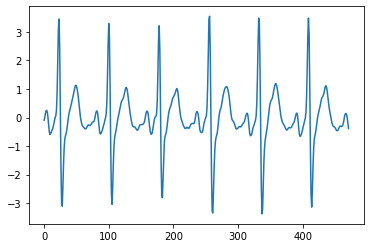

In [ ]:
plt.plot(lead1[0][2848])

In [ ]:
battiti1 = np.concatenate(lead1_pad, axis=0)
battiti2 = np.concatenate(lead2_pad, axis=0)

In [ ]:
battiti1.shape

(212674, 512)

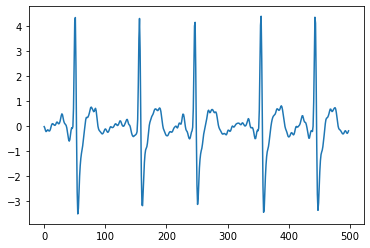

In [ ]:
plt.plot(battiti1[2853])

In [ ]:
# Save also the beats to use them into a possible deep learning model
np.save(r'', battiti1) #insert destination path (.npy)
np.save(r'', battiti2) #insert destination path (.npy)